Количество изображений: 5000
Количество аннотаций: 25502
Распределение классов:
class
helmet    18966
head       5785
person      751
Name: count, dtype: int64


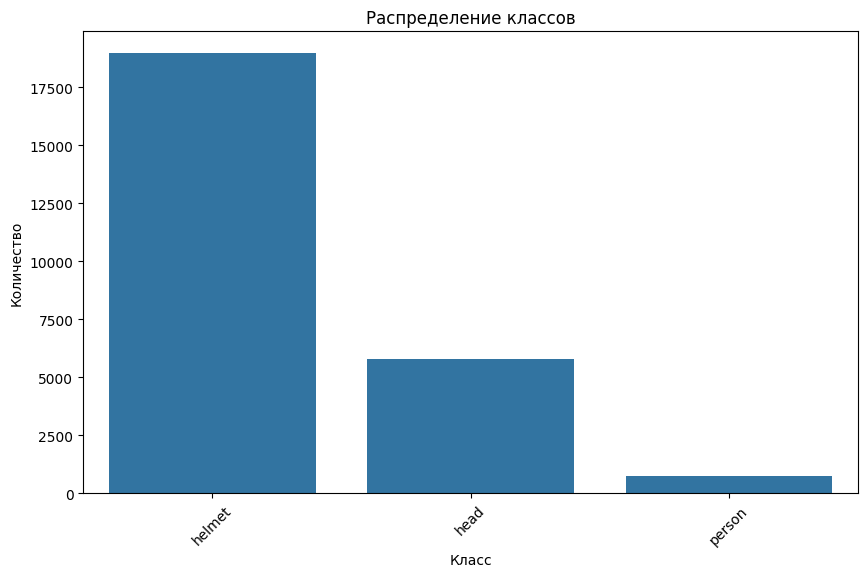

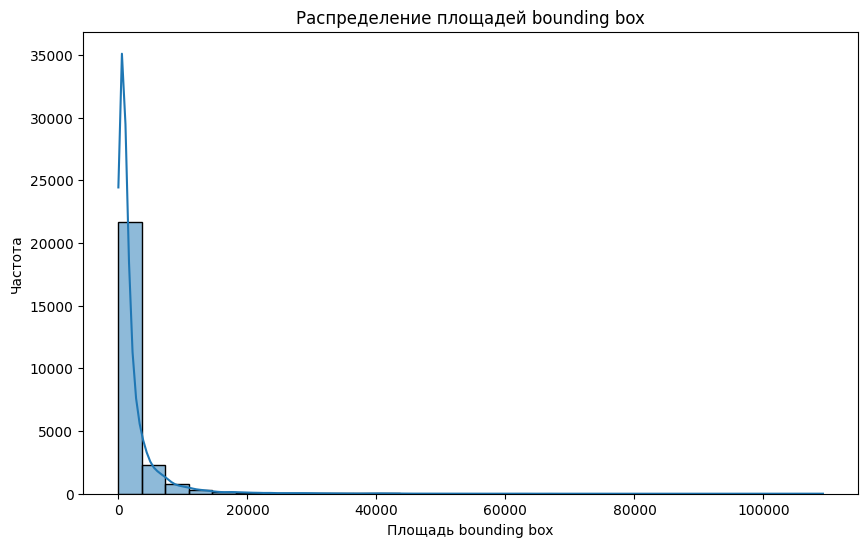

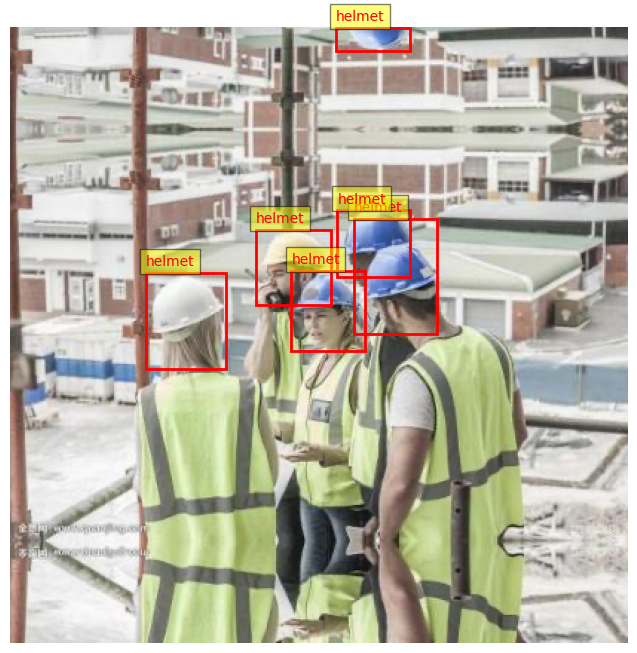

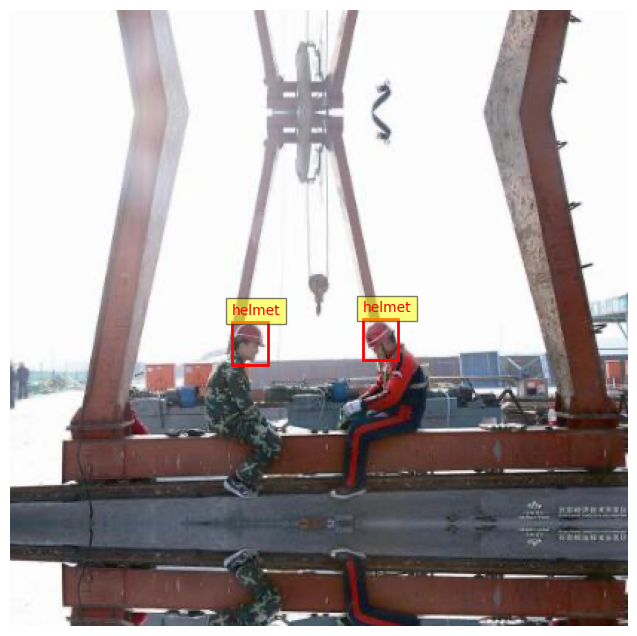

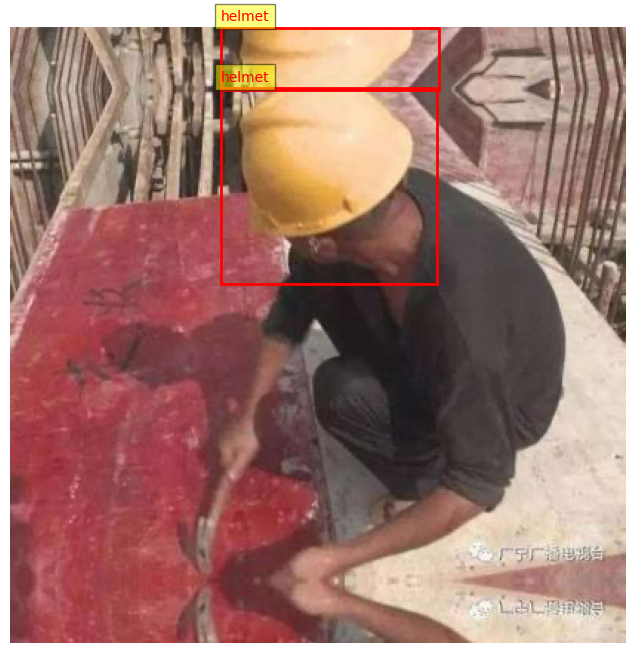

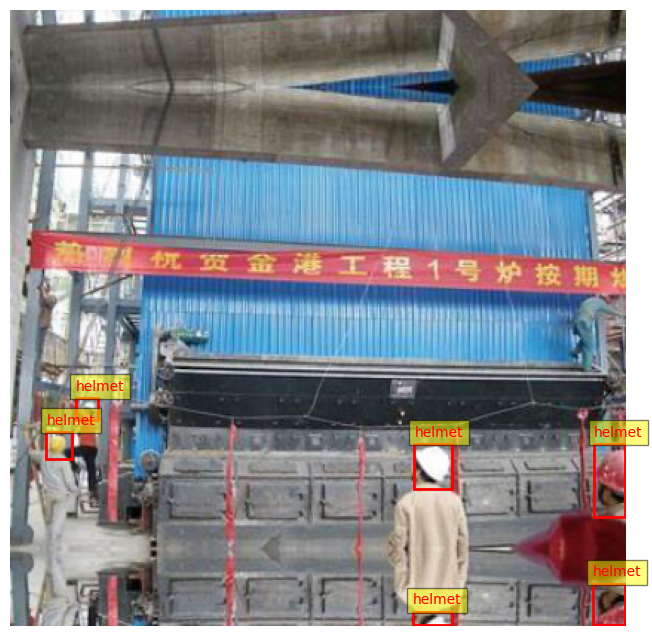

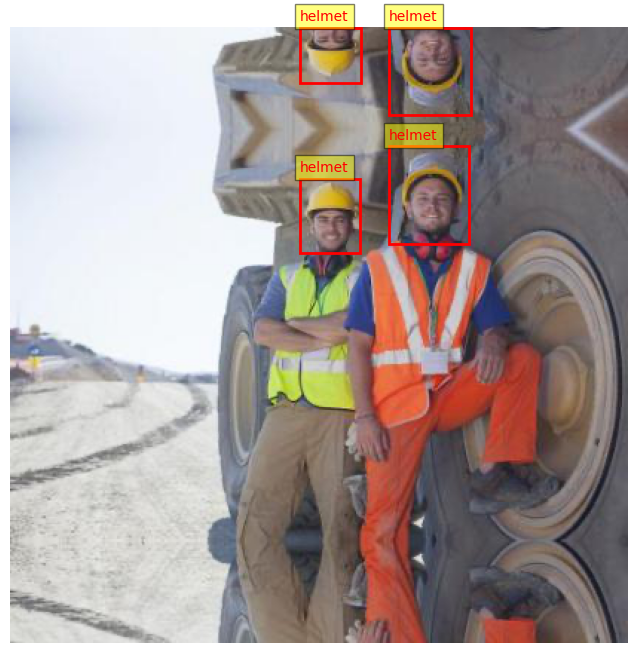

Визуализация изображений с классом 'head':


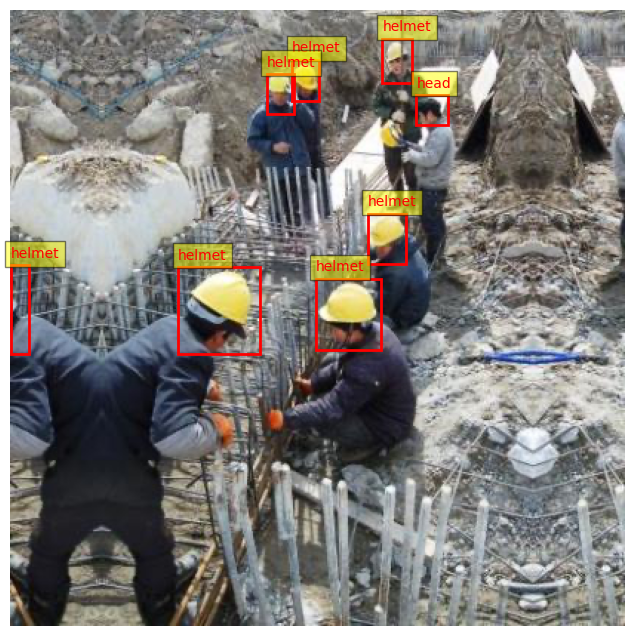

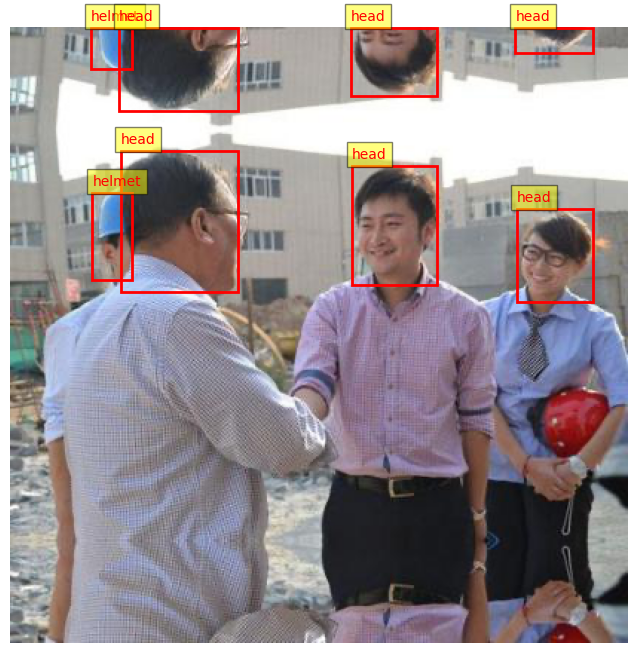

Визуализация изображений с классом 'person':


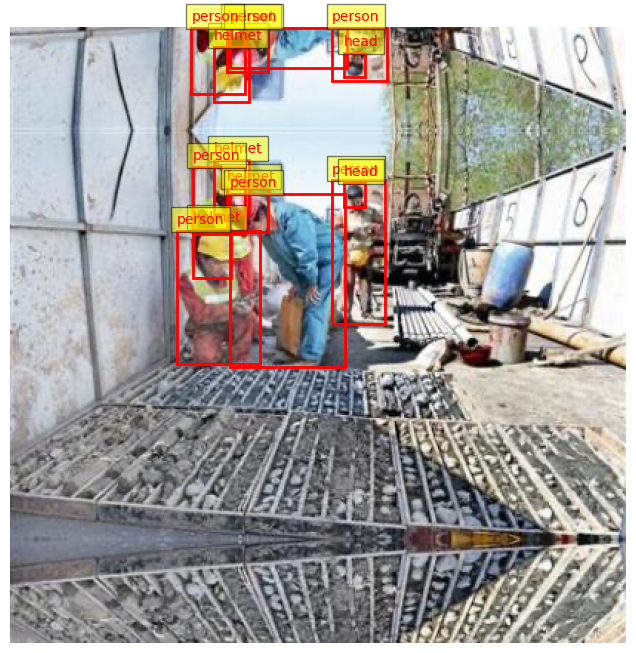

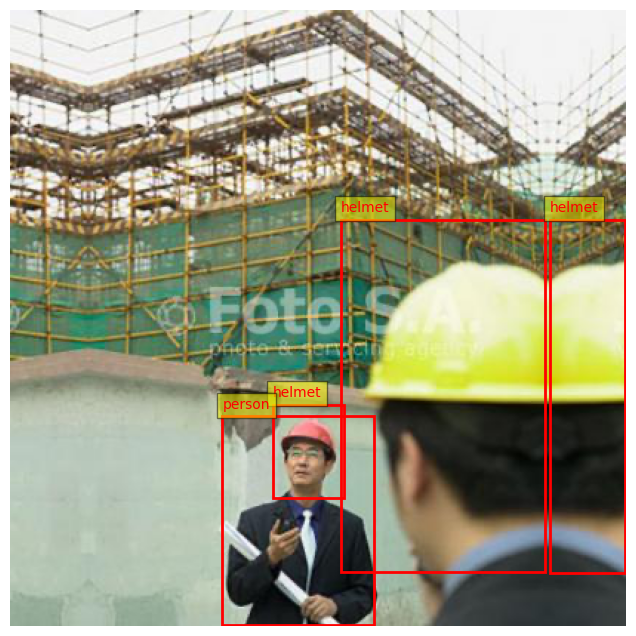

Результаты EDA сохранены в /Users/muzafarov/Desktop/Datasets/SafetyHelmetDetection/eda_results


In [10]:
import os
import cv2
from matplotlib.patches import Rectangle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xml.etree import ElementTree as ET
from pathlib import Path

# Путь к датасету
data_dir = Path('/Users/muzafarov/Desktop/Datasets/SafetyHelmetDetection')
annotations_dir = data_dir / 'annotations'
images_dir = data_dir / 'images'

# Вспомогательные функции
def parse_annotation(file_path):
    """Разбирает XML-файл аннотаций и возвращает детали в виде списка словарей."""
    tree = ET.parse(file_path)
    root = tree.getroot()
    objects = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        objects.append({
            'filename': root.find('filename').text,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })
    return objects

# Загрузка всех аннотаций
annotations = []
for annotation_file in annotations_dir.glob('*.xml'):
    annotations.extend(parse_annotation(annotation_file))

# Конвертация в DataFrame
annotations_df = pd.DataFrame(annotations)

# Исследовательский анализ данных (EDA): обзор данных
print("Количество изображений:", len(annotations_df['filename'].unique()))
print("Количество аннотаций:", len(annotations_df))
print("Распределение классов:")
print(annotations_df['class'].value_counts())

# Визуализация распределения классов
plt.figure(figsize=(10, 6))
sns.countplot(data=annotations_df, x='class', order=annotations_df['class'].value_counts().index)
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

# Анализ размеров bounding box
annotations_df['box_width'] = annotations_df['xmax'] - annotations_df['xmin']
annotations_df['box_height'] = annotations_df['ymax'] - annotations_df['ymin']
annotations_df['box_area'] = annotations_df['box_width'] * annotations_df['box_height']

plt.figure(figsize=(10, 6))
sns.histplot(annotations_df['box_area'], bins=30, kde=True)
plt.title('Распределение площадей bounding box')
plt.xlabel('Площадь bounding box')
plt.ylabel('Частота')
plt.show()

def plot_image_with_boxes(image_path, image_annotations):
    image = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    ax = plt.gca()
    for _, row in image_annotations.iterrows():
        rect = Rectangle((row['xmin'], row['ymin']), row['box_width'], row['box_height'], 
                         linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        plt.text(row['xmin'], row['ymin'] - 5, row['class'], color='red', fontsize=10, 
                 bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# Отображение примеров изображений
example_files = annotations_df['filename'].unique()[:5]
for file in example_files:
    image_path = images_dir / file
    image_annotations = annotations_df[annotations_df['filename'] == file]
    plot_image_with_boxes(image_path, image_annotations)

# Визуализация двух изображений с классом 'head' и двух с классом 'person'
def plot_examples_by_class(class_name, num_examples=2):
    class_files = annotations_df[annotations_df['class'] == class_name]['filename'].unique()[:num_examples]
    for file in class_files:
        image_path = images_dir / file
        image_annotations = annotations_df[annotations_df['filename'] == file]
        plot_image_with_boxes(image_path, image_annotations)

print("Визуализация изображений с классом 'head':")
plot_examples_by_class('head', num_examples=2)

print("Визуализация изображений с классом 'person':")
plot_examples_by_class('person', num_examples=2)

# Сохранение результатов анализа
output_dir = data_dir / 'eda_results'
os.makedirs(output_dir, exist_ok=True)
annotations_df.to_csv(output_dir / 'annotations_analysis.csv', index=False)
print(f"Результаты EDA сохранены в {output_dir}")


## Выводы



### Наблюдается дисбаланс с перевесом в сторону аннотаций с касками.
### Всё-таки нам нужно детектировать людей без касок (класс head), если мы хотим это делать внутри цеха. Так как внутри цеха все обязаны находиться в СИЗ.

### Необходимо будет поработать с данным датасетом, чтобы постараться выровнить классы.